In [2]:
# Library untuk sampling data dari dataset di kaggle
import os
import random
import shutil
from pathlib import Path

# Library untuk graph dan visualisasi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#Library untuk deep learning
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S             # model untuk transfer learning
from tensorflow.keras import layers, models                           # deeplearning layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # untuk training epoch

2025-07-10 14:31:09.715779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752157869.911712      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752157869.970425      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Fungsi untuk sampling data**

Karena ukuran dataset yang besar (500k gambar) kami hanya akan menggunakan sample data untuk training, validasi, dan testing. Fungsi mengambil sejumlah **samples_per_class** data dengan random sampling dari tiap-tiap kelas pada **src_dir** kemudian menulisnya ke **dst_dir**

In [ ]:
# def sample_images(src_dir, dst_dir, samples_per_class):
#     for class_name in os.listdir(src_dir):
#         class_path = os.path.join(src_dir, class_name)
#         if not os.path.isdir(class_path):
#             continue

#         images = os.listdir(class_path)
#         sampled = random.sample(images, min(samples_per_class, len(images)))

#         dst_class_path = os.path.join(dst_dir, class_name)
#         os.makedirs(dst_class_path, exist_ok=True)

#         for img_name in sampled:
#             src_img = os.path.join(class_path, img_name)
#             dst_img = os.path.join(dst_class_path, img_name)
#             shutil.copyfile(src_img, dst_img)

# **Sampling data untuk subfolder train, val, dan test**

In [ ]:
# # Correct writable destination
# sample_images(
#     "/kaggle/input/poultry-diseases/data/data/train",
#     "/kaggle/working/sample/train",
#     samples_per_class=3000
# )

# sample_images(
#     "/kaggle/input/poultry-diseases/data/data/val",
#     "/kaggle/working/sample/val",
#     samples_per_class=400
# )

# sample_images(
#     "/kaggle/input/poultry-diseases/data/data/test",
#     "/kaggle/working/sample/test",
#     samples_per_class=400
# )


# **Menyatakan data train, val, dan test**

mengambil data yang sudah disample dari direktori baru "sample" 

In [ ]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/sample_data/train',
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'  # for multi-class classification
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/sample_data/val',
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/sample_data/test',
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

Found 12000 files belonging to 4 classes.


I0000 00:00:1752158175.627001      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1600 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.


# **Arsitektur Model dengan EfficientNetV2S**

In [6]:
# Menyatakan EfficientNetV2S sebagai base_model 
base_model = tf.keras.applications.EfficientNetV2S(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# freeze base_model untuk trainig layers activation dahulu
base_model.trainable = False  

# arsitektur model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),           
    
    # Dense + BatchNorm + ReLU + Dropout block
    layers.Dense(128, use_bias=False),           
    layers.BatchNormalization(),                 
    layers.Activation('relu'),                   
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# **Training Model dengan EarlyStopping**

In [7]:
# menyatakan EarlyStopping
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',    # melihat perubahan pada akurasi model  
        patience=3,                # melihat perubahan akurasi setiap 3 epoch   
        mode='max',                # memberitahu Keras bahwa nilai yang lebih tinggi dari val_accuracy lebih baik   
        restore_best_weights=True     
    )
]

# trainig model menggunakan 25 epoch untuk mengantisipasi EarlyStopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25


I0000 00:00:1752158283.785327     101 service.cc:148] XLA service 0x7efe1c002420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752158283.785930     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752158287.464229     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.2891 - loss: 1.5482   

I0000 00:00:1752158306.930834     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 90s 97ms/step - accuracy: 0.6541 - loss: 0.8601 - val_accuracy: 0.7925 - val_loss: 0.5211
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.7653 - loss: 0.6055 - val_accuracy: 0.7994 - val_loss: 0.4973
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.7814 - loss: 0.5557 - val_accuracy: 0.8175 - val_loss: 0.4769
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8072 - loss: 0.5109 - val_accuracy: 0.8106 - val_loss: 0.4707
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8164 - loss: 0.4839 - val_accuracy: 0.8144 - val_loss: 0.4728
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8135 - loss: 0.4726 - val_accuracy: 0.8169 - val_loss: 0.4635


# **Akurasi setelah training**

In [8]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8246 - loss: 0.4412
Test Accuracy: 0.79


#### mendapatkan akurasi sebesar 0.79

# ***Fine tuning* base_model setelah training model**

In [9]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history_fine = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25


E0000 00:00:1752158751.251921     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752158751.441323     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752158751.911815     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752158752.110604     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752158752.680601     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

375/375 ━━━━━━━━━━━━━━━━━━━━ 263s 242ms/step - accuracy: 0.6823 - loss: 0.8585 - val_accuracy: 0.7950 - val_loss: 0.5581
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 211ms/step - accuracy: 0.7828 - loss: 0.5817 - val_accuracy: 0.8244 - val_loss: 0.4623
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 209ms/step - accuracy: 0.8146 - loss: 0.4775 - val_accuracy: 0.8431 - val_loss: 0.4129
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 209ms/step - accuracy: 0.8377 - loss: 0.4288 - val_accuracy: 0.8537 - val_loss: 0.3734
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 209ms/step - accuracy: 0.8629 - loss: 0.3629 - val_accuracy: 0.8725 - val_loss: 0.3485
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 210ms/step - accuracy: 0.8768 - loss: 0.3283 - val_accuracy: 0.8800 - val_loss: 0.3307
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 210ms/step - accuracy: 0.8888 - loss: 0.3021 - val_accuracy: 0.8806 - val_loss: 0.3205
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 209ms/step - accuracy: 0.8961 - loss: 0.2764 - va

# **Tes akurasi model setelah base_model *fine tuning***

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9123 - loss: 0.2745
Test Accuracy: 0.90


#### kita mendapatkan akurasi akhir 0.9

# **Fungsi plot accuracy dan loss**

In [18]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

# **Fungsi Confusion Matrix**

In [19]:
def plot_confusion_matrix(model, dataset, class_names):
    """
    Plot confusion matrix for a Keras model and a given dataset.
    
    Parameters:
    - model: Trained Keras model
    - dataset: tf.data.Dataset (e.g., test_ds)
    - class_names: list of class names corresponding to output labels
    """
    # STEP 1: Get true labels and predicted labels
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))     # Convert one-hot to class index
        y_pred.extend(np.argmax(preds, axis=1))

    # STEP 2: Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # STEP 3: Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Graph Accuracy dan Training Loss sebelum base_model *fine tuning*

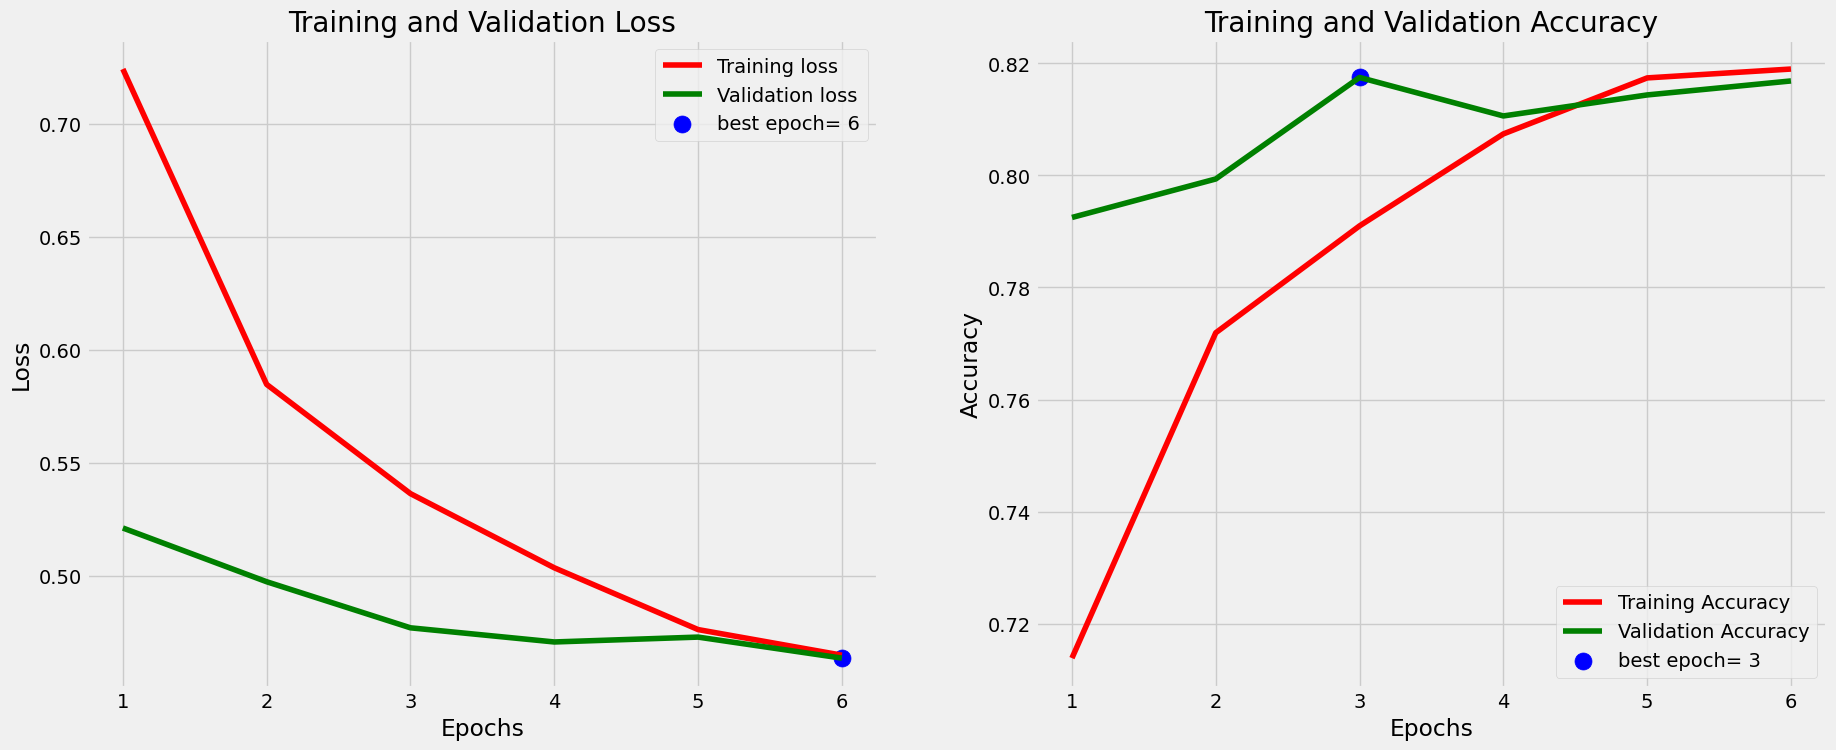

In [22]:
plot_training(history)

## Graph Accuracy dan Training Loss setelah base_model *fine tuning*

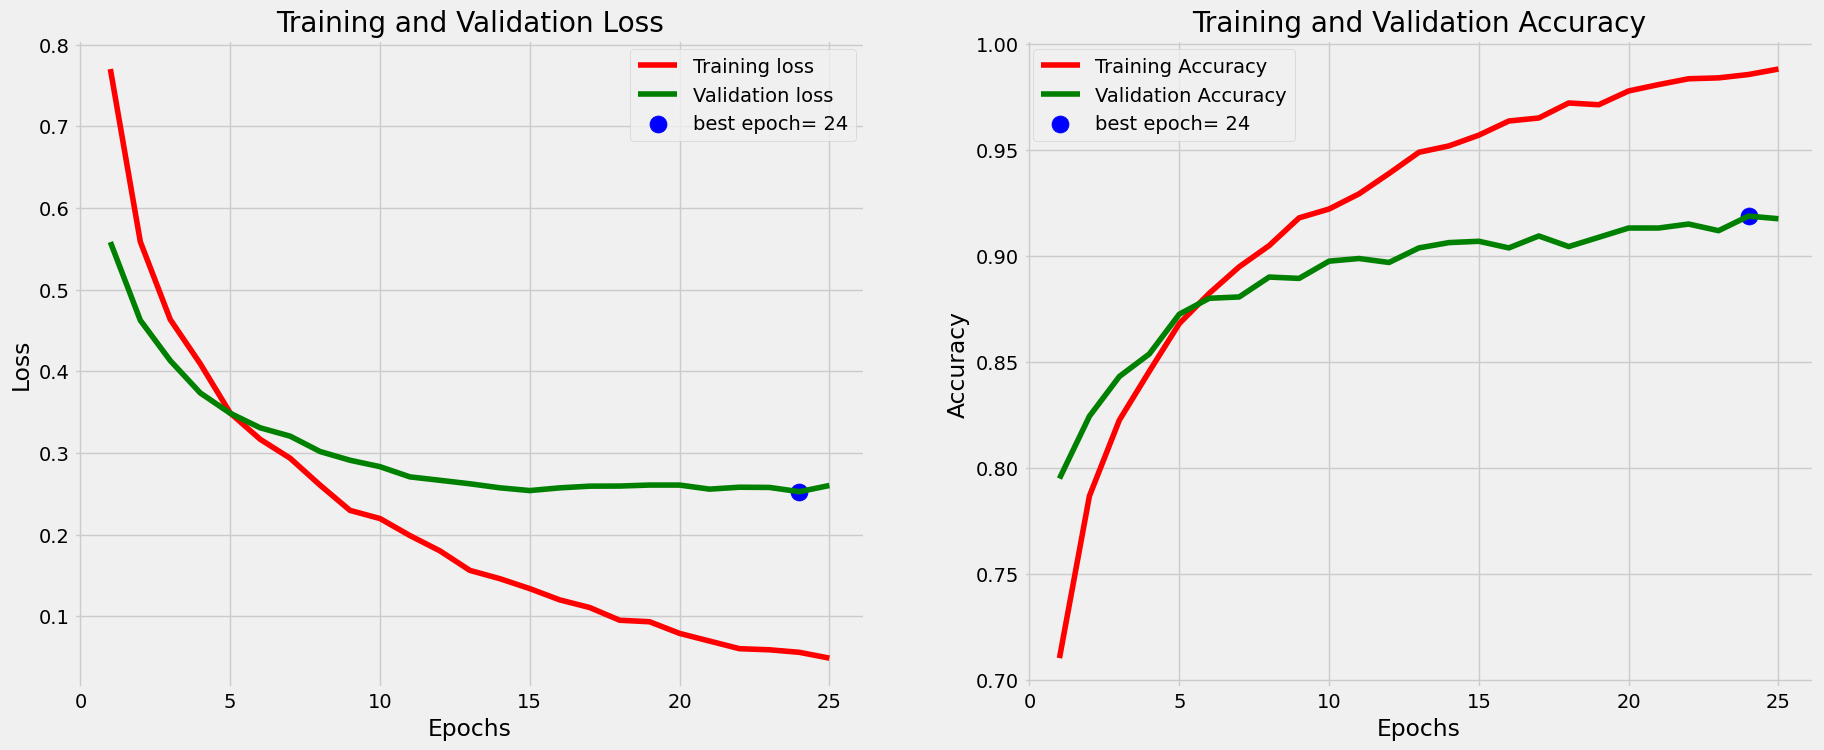

In [23]:
plot_training(history_fine)

# **Graph Confusion Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━

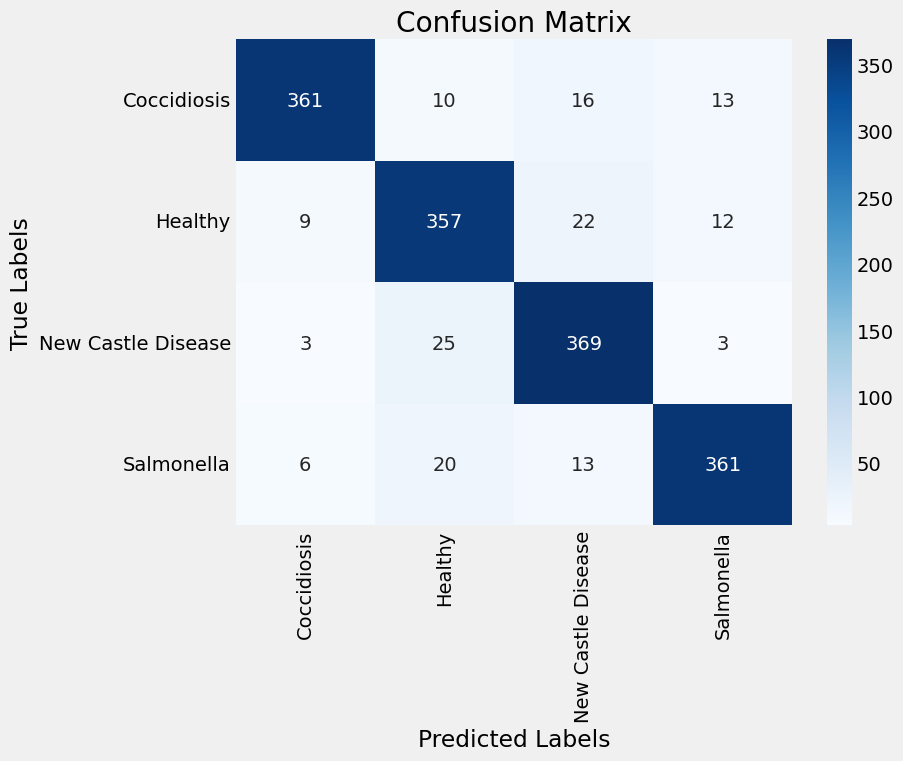

In [16]:
class_names = ['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']
plot_confusion_matrix(model, test_ds, class_names)

# **Save model**

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('healthyHen_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpawzmiv68'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_513')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139632533124112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632530409232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632530408272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632530409040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632530408656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632530407696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632530409808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632530408464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632533126992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139632530410384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1396325304

W0000 00:00:1752161237.433105      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752161237.433156      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1752161237.811404      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
